In [43]:
import string
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.model_selection import (train_test_split, learning_curve, cross_val_score, cross_val_predict, 
ShuffleSplit, KFold)
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "!", "#", "$", "%", "&", "(", ")", "*", "+", "-",
                            ".", "/", ":", ";", "<", "=", ">", "?", "@", "[", "]", "^", "_", "`", "{", "|", "}", "~"]

ignore_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
                'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
                'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
                'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
                'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
                'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
                'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
                'should', 'now', 'uses', 'use', 'using', 'used', 'one', 'also']

dataset = pd.read_csv(r'TrainDataset.csv', sep=",", engine='python')
dataset=dataset.dropna()
print("Old shape:", dataset.shape)


# Data cleaning function
def clean_data(dataset):
    # Remove punctuations
    dataset['text'] = dataset['text'].str.replace(',', " ")
    dataset['text'] = dataset['text'].str.replace('“', " ")
    dataset['text'] = dataset['text'].str.replace('’', " ")
    # Make sure any double-spaces are single
    dataset['text'] = dataset['text'].str.replace('  ', ' ')
    dataset['text'] = dataset['text'].str.replace("\n", " ").replace("\r", " ")
    dataset['text'] = dataset['text'].str.replace("  ", " ")
    # Drop duplicate rows
    dataset.drop_duplicates(subset=['text'], inplace=True)
    print("New shape:", dataset.shape)
    return dataset


data = clean_data(dataset)
dataframe = data


def Remove_StopWords(docs):
    lemmas = []
    for tok in docs:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
        tokens = lemmas
        tokens = [tok for tok in tokens if tok not in STOPLIST]
#         tokens = [w.lower() for w in tokens if w not in ignore_words]
        tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


rows_list = []

start = time.time()
for output in dataframe.text:
    doc = nlp(output)
    vocabulary = Remove_StopWords(doc)
    vectorizer = CountVectorizer(tokenizer=vocabulary,max_features=15,stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))    
    # Part of Speech (POS) Tagging
    diction = [x.lemma_ for x in [y for y in nlp(str(vectorizer.tokenizer)) if not y.is_stop and y.pos_ != 'PUNCT']]   
    rows_list.append(diction)
    
df = pd.DataFrame(rows_list)
df['News'] = df[df.columns[0:]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df["Type"] = dataframe["label"]

# duplicate_word_list = [word for word, count in Counter(df["News"]).most_common() if count > 1]
dfModel = pd.DataFrame(df[["News", "Type"]])

dfModel=dfModel.dropna()

end = time.time()
print("execution time is",end - start)

Old shape: (173, 5)
New shape: (172, 5)
execution time is 186.13437914848328


In [48]:
#CREATING_LEARNING_CURVE_FUNCTION
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    plt.gca().invert_yaxis()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Support Vector Machine Classifier 

Training Accuracy  1.0
Training Validated scores: Mean: 0.62 (+/- Std: 0.04)

R2 Score: -0.7647058823529416

Predicted Accuracy score 56.67%
Misclassified samples: 13

execution time is 1.0765221118927002


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

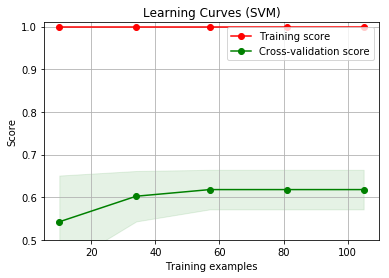

In [55]:
# SVM Classifier

from sklearn.svm import SVC
from sklearn import svm
start = time.time()

tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X = dfModel.News.values
X_tf_idf = tf_idf.fit_transform(X)
y=dfModel.Type.values

#  Train the classifier
svm = svm.SVC(kernel='rbf', random_state=0, gamma=3, C=1.0)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2)

# get predictions for article section
svm.fit(X_train, y_train)
scores = cross_val_score(svm, X_train, y_train, cv=10)

print("Support Vector Machine Classifier \n")
print("Training Accuracy ",svm.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = svm.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
# cross_val_score(svm,X_tf_idf , y, cv=cv)  
plot_learning_curve(svm, title, X_tf_idf, y, ylim=(0.5, 1.01), cv=cv, n_jobs=10)

Logistic Regression Classifier 

Training Accuracy  0.9333333333333333
Training Validated scores: Mean: 0.60 (+/- Std: 0.04)

R2 Score: -0.5789473684210531

Predicted Accuracy score 63.33%
Misclassified samples: 11

execution time is 0.5852150917053223


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

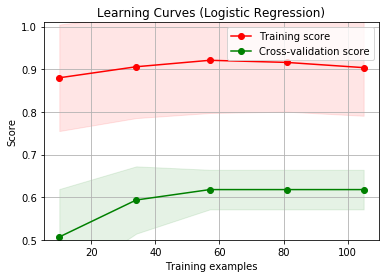

In [50]:
# Logit Classifier
start = time.time()

tf_idf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X = dfModel.News.values
X_tf_idf = tf_idf.fit_transform(X)
y = dfModel.Type.values

#  Train the classifier
logit = LogisticRegression(solver='liblinear')

X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2)

logit.fit(X_train, y_train)

scores = cross_val_score(logit, X_train, y_train, cv=10)
print("Logistic Regression Classifier \n")
print("Training Accuracy ",logit.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = logit.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
# cross_val_score(svm,X_tf_idf , y, cv=cv)  
plot_learning_curve(logit, title, X_tf_idf, y, ylim=(0.5, 1.01), cv=cv, n_jobs=10)

Naive Bayes Classifier 

Training Accuracy  0.9904761904761905
Training Validated scores: Mean: 0.49 (+/- Std: 0.26)

R2 Score: -0.9396551724137934

Predicted Accuracy score 55.56%
Misclassified samples: 20

execution time is 0.4744539260864258


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

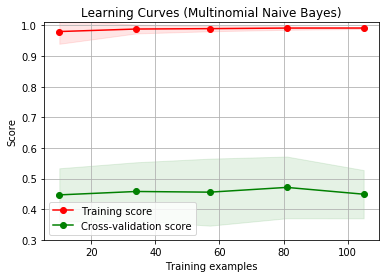

In [51]:
#countvectorizer does the bag of words for us 
start = time.time()

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
x_vectors = bigram_vectorizer.fit_transform(dfModel.News.values)
y_vectors=dfModel.Type.values

# Build the classifier
clf = MultinomialNB(alpha=.01)
X_train, X_test, y_train, y_test = train_test_split(x_vectors, y_vectors, test_size=0.3)

#  Train the classifier
clf.fit(X_train,y_train)

print("Naive Bayes Classifier", '\n')
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Training Accuracy ",clf.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = clf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Multinomial Naive Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0, train_size=0.7)
plot_learning_curve(clf, title, x_vectors, y_vectors, ylim=(0.3, 1.01), cv=cv, n_jobs=10)

Random Forest Classfier
Training Accuracy  0.9666666666666667
Training Validated scores: Mean: 0.54 (+/- Std: 0.26)

R2 Score: -0.8055555555555551

Predicted Accuracy score 56.67%
Misclassified samples: 13

execution time is 0.8975520133972168


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

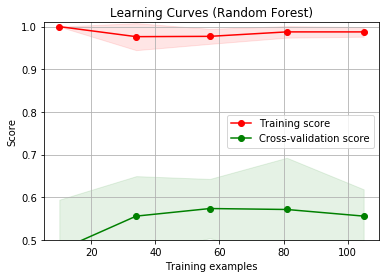

In [52]:
# Random_forest_classifier
start = time.time()

vectorizer = CountVectorizer(analyzer = 'word',stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
x_vectors = vectorizer.fit_transform(dfModel.News.values)
y = dfModel.Type.values
X_train, X_test, y_train, y_test = train_test_split(x_vectors, y, test_size=0.2, random_state=42) # Get a training and test dataset

# n_estimators is the number of random forests to use
# n_jobs says to use all processors available
rf = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
rf.fit(X_train, y_train)

print("Random Forest Classfier")
scores = cross_val_score(rf, X_train, y_train, cv=10)
print("Training Accuracy ",rf.score(X_train, y_train))
print("Training Validated scores: Mean: %0.2f (+/- Std: %0.2f)" % (scores.mean(), scores.std() * 2))
print()

y_pred = rf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print ("R2 Score:", accuracy)
print()

print("Predicted Accuracy score {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print()    

end = time.time()
print("execution time is",end - start)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0, train_size=0.7)
# cv=KFold(n_splits=100, random_state=None, shuffle=True)
plot_learning_curve(rf, title, x_vectors, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

In [93]:
# kf = KFold(n_splits = 10, shuffle = True)
# scores = []
# for i in range(0,10):
#     result = next(kf.split(X_tf_idf), None)
#     x_train = X_tf_idf[result[0]]
#     x_test = X_tf_idf[result[1]]
#     y_train = y[result[0]]
#     y_test = y[result[1]]
#     model = svm.fit(x_train,y_train)
#     predictions = svm.predict(x_test)
#     scores.append(model.score(x_test,y_test))
# print('Scores from each Iteration: ', scores)
# print('Average K-Fold Score :' , np.mean(scores))